# CZ1115 - Team WIN Data Science Project 

### Model Name: Neural Network Model - Long Short Term Memory [NNM - LSTM]

---

> **So far, we have tested on `Natural Language Proccessing - Multi-Label Classifier, the multinomial Naive Bayes & Linear Support Vector Classification` to predict genres from a movie's overview. The performance of `Natural Language Proccessing - Multi-Label Classifier` remains the best so far in terms of F1 score, so in addition to exploring another new model, we added other constraints in our testing which we will be shown below**

# 0. Import required libraries

In [1]:
import requests,json,csv,os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import time
from nltk.stem import WordNetLemmatizer
import sys
from sklearn.metrics import accuracy_score
sb.set()

<b>Our API Key: '9c9de4f24b3a171f5962aaa463a6b351'<b>

# Data Preparation




1.1 We made use the API (the discover function) to obtain values for our datset. Each call only give us ~20 entries as the data is split into different 'pages'. Hence, we had to iterate through the pages to obtain more data for our dataset

The table below shows all the genres present in The Movie Database API (TMDB):

| **genres_id** | 28 | 12 | 16 | 35 | 80 | 99 | 18 | 10751 | 14 | 36 | 27 | 10402 | 9648 | 10749 | 878 | 10770 | 53 | 10752 | 37 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **genres_name** | Action | Adventure | Animation | Comedy | Crime | Documentary | Drama | Family | Fantasy | History | Horror | Music | Mystery | Romance | Science Fiction | TV Movie | Thriller | War | Western |
<br><br>

> We originally tested our model with all 19 genres, however, prediction accuracy was very low, due to gap in the amount data per genre, causing an imbalanced learning problem.

Therefore we decided on using 5 out of the 19 genres to test and train our model on, and the genres are:

| **genres_id** | 35 | 99 | 18 | 10749 | 53 |
| --- | --- | --- | --- | --- | --- |
| **genres_name** | Comedy | Documentary | Drama | Romance | Thriller |

> Reason for genre choices:
> * Distinct descriptions (e.g. unlike Horror, Mystery against Thriller)
> * Most balanced combination of 5 genres
> * Substantial amount of data for each genre

We made use of the built-in API function, without_genres, by extending our API URL caller with genres that are not our targeted genres, using their IDs.

In [2]:
discover_api_url = 'https://api.themoviedb.org/3/discover/movie?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-Us&without_genres=12,16,28,80,10751,14,36,27,10402,9648,878,10770,10752,37'


discover_api = requests.get(discover_api_url).json()
movies = discover_api["results"]
for page in range(2, discover_api["total_pages"]+1): # if want all pages, change end range to "discover_api["total_pages"]+1"
    try:
      discover_api = requests.get(discover_api_url + f"&page={page}").json()
      movies.extend(discover_api["results"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

The table below shows accuracy and F1-score for 3 models we tested and train on:

| **Models** | NLP - MLC | multinomialNB | LinearSVC |
| --- | --- | --- | --- |
| **Accuracy** | 0.311902 | 0.343783 | 0.310840 |
| **F1-score** | 0.703772 | 0.652189 | 0.619505 |

For each of these models, 5 distinct genres are used which are: 

| **genres_id** | 35 | 99 | 18 | 10749 | 53 |
| --- | --- | --- | --- | --- | --- |
| **genres_name** | Comedy | Documentary | Drama | Romance | Thriller |

But in reality, genres won't be as distinct as the ones we have chosen. So what about genres where the words used in overview writing is similar, like Thriller & Horror?

>Hence, we tested with similar genres and reduced the number of classes further, hoping it will show improvements on our results. 



| **genres_id** | 27 | 53 | 
| --- | --- | --- | 
| **genres_name** | Horror | Thriller |

> Reason for genre choices:
> * Similar descriptions 
> * Most balanced combination of 2 genres
> * Substantial amount of data for both genres

We made use of the built-in API function, without_genres, by extending our API URL caller with genres that are not our targeted genres, using their IDs.

In [3]:
discover_api_url = 'https://api.themoviedb.org/3/discover/movie?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-Us&without_genres=28,12,16,35,80,99,18,10751,14,36,10402,9648,10749,878,10770,10752,37'


discover_api = requests.get(discover_api_url).json()
movies = discover_api["results"]
for page in range(2, discover_api["total_pages"]+1): # if want all pages, change end range to "discover_api["total_pages"]+1"
    try:
      discover_api = requests.get(discover_api_url + f"&page={page}").json()
      movies.extend(discover_api["results"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

1.2 Now we populate different lists according to what data we require.
> Required data:
*   Titles
*   Overview
*   Genre ID

Notice that for genres we went on to obtain their ID instead of the name. This is because the genres are in dictionary form, so the IDs act as the keys while the genres as the values.

In [4]:
# get all the titles and put into a list
titles = []
for i , film in enumerate(movies):
  titles.append(film['original_title'])

# get all the overviews and put into a list
overviews = []
for i , film in enumerate(movies):
  overviews.append(film['overview'])

# get all the genre IDs and put into a list
genres = []
for i , film in enumerate(movies):
  genres.append(film['genre_ids'])

1.3 We now repeat the same process as in 1.1 with the genre function of the API, to obtain the names of the genre and link them to their respective IDs.

In [5]:
#get genre movie list from TMDb (to convert ID to name of genre)
discover_genre_api_url = 'https://api.themoviedb.org/3/genre/movie/list?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-US'
discover_genre_api = requests.get(discover_genre_api_url).json()
genre_list = discover_genre_api["genres"]
time.sleep(0.01)
for page in range(2, discover_api["total_pages"]+1): 
    try:
      discover_genre_api = requests.get(discover_genre_api_url + f"&page={page}").json()
      genre_list.extend(discover_genre_api["genres"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

#make it a dictionary
dict = {}
for i, film_genre in enumerate(genre_list):
    dict[film_genre['id']] = film_genre['name']

#convert genre IDs to names
for i in range(len(genres)):
    for j in range(len(genres[i])):
        genres[i][j] = dict[genres[i][j]]

1.4 Now that we have the data we want, we put it into a dataframe in preparation for data cleaning.

In [6]:
dat = {'titles': titles, 'overviews': overviews, 'genres': genres}
df = pd.DataFrame(data=dat)
df.head()

,titles,overviews,genres
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",[Horror]
1,Wrong Turn,Jen and a group of friends set out to hike the...,"[Horror, Thriller]"
2,The Unfamiliar,"A British Army doctor comes back from a war, t...","[Thriller, Horror]"
3,Occidente,"A fugitive film director in exile, called H, r...",[Thriller]
4,Ruega por nosotros,"In a desolate supermarket, a religious woman's...",[]


# 2. Data Cleaning* 

##### * more cleaning done in part 4

2.1 As we explored the data we obtained from the TMDB, we encountered `empty lists in the genre column` and also `empty strings in the overview column`.

Hence, we iterated through the whole dataframe, dropping any row that contained the empty list/strings as it would not help us in creating an accurate genre predictor.

In [7]:
# check for empty list 
# empty = (df.loc[df['genres'].str.len()<1])
# print(empty)

# To view all rows: 
# pd.set_option('display.max_rows', None)

# drop empty list from genre column
for i, row in enumerate(df['genres']):
  if row == []:
    df = df.drop([i])

# drop empty strings from overviews column
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset=["overviews"], inplace=True)
df

,titles,overviews,genres
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",[Horror]
1,Wrong Turn,Jen and a group of friends set out to hike the...,"[Horror, Thriller]"
2,The Unfamiliar,"A British Army doctor comes back from a war, t...","[Thriller, Horror]"
3,Occidente,"A fugitive film director in exile, called H, r...",[Thriller]
5,Яга. Кошмар тёмного леса,The young family who moved to a new apartment ...,[Horror]
...,...,...,...
9982,Porcelain Rising,A menacing porcelain doll comes to life at nig...,[Horror]
9989,ฮาชิมะ โปรเจกต์ ไม่เชื่อ ต้องลบหลู่,Hashima Island was once the most densely popul...,[Horror]
9990,Petrified,When a black market antiques deal is botched b...,[Horror]
9992,Herbert West: Reanimator,"Pursued by the police, an ambitious neuroscien...",[Horror]


# 3. Data Visualization

3.1 To be able to better visualize our data, we used the explode function to transform each element of the genre list to a row, replicating index values. We further check for empty rows and make to drop them to get more accurate data.

In [8]:
df2 = df.explode('genres')
df2.dropna(subset = ["genres"], inplace=True)
df2

,titles,overviews,genres
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",Horror
1,Wrong Turn,Jen and a group of friends set out to hike the...,Horror
1,Wrong Turn,Jen and a group of friends set out to hike the...,Thriller
2,The Unfamiliar,"A British Army doctor comes back from a war, t...",Thriller
2,The Unfamiliar,"A British Army doctor comes back from a war, t...",Horror
...,...,...,...
9982,Porcelain Rising,A menacing porcelain doll comes to life at nig...,Horror
9989,ฮาชิมะ โปรเจกต์ ไม่เชื่อ ต้องลบหลู่,Hashima Island was once the most densely popul...,Horror
9990,Petrified,When a black market antiques deal is botched b...,Horror
9992,Herbert West: Reanimator,"Pursued by the police, an ambitious neuroscien...",Horror


3.2 We now create a dictionary to store the genre names as the key and the number of occurence of a particular genre as the value.

In [9]:
categories = {}
for item in df2['genres']:
        if item in categories:
            categories[item] += 1
        else:
            categories[item] = 0
    
print("Number of categories: {}".format(len(categories)))
print(categories)

Number of categories: 2
{'Horror': 4671, 'Thriller': 2846}


3.3 To see how many occurences per genre, we plot a bar graph for comparison. 

<BarContainer object of 2 artists>

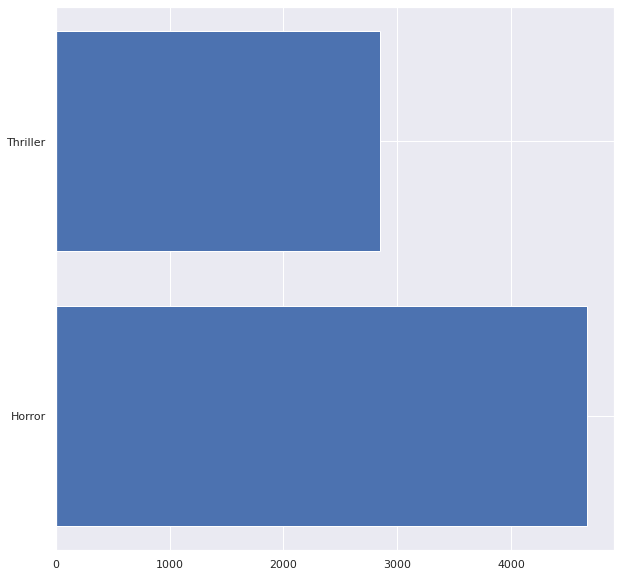

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.barh(list(categories.keys()), list(categories.values()))

# 4. Data Preparation for Genre Prediction Model

4.1 To be able to better predict from the overviews, we had to 'clean' each overview. Our function, clean_text, removes any punctuation marks and converts all text to its lowercase value. 

We also applied word lemmatization, the process of converting a word to its base form. As compared to stemming, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

To compare our results, We create a new column in our dataframe, clean_overview.

In [11]:
# download nltk library first
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # convert text to lowercase
    text = text.lower() 
    x = text.split()

    # apply lemmattization to words in overview
    for i, j in enumerate(x):
      x[i] = wordnet_lemmatizer.lemmatize(j,pos="v")

    # remove whitespaces 
    text = ' '.join(x) 
    
    return text

df['clean_overview'] = df['overviews'].apply(lambda x: clean_text(x))
df

,titles,overviews,genres,clean_overview
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",[Horror],alice a young hear impair girl who after a sup...
1,Wrong Turn,Jen and a group of friends set out to hike the...,"[Horror, Thriller]",jen and a group of friends set out to hike the...
2,The Unfamiliar,"A British Army doctor comes back from a war, t...","[Thriller, Horror]",a british army doctor come back from a war thi...
3,Occidente,"A fugitive film director in exile, called H, r...",[Thriller],a fugitive film director in exile call h retur...
5,Яга. Кошмар тёмного леса,The young family who moved to a new apartment ...,[Horror],the young family who move to a new apartment o...
...,...,...,...,...
9982,Porcelain Rising,A menacing porcelain doll comes to life at nig...,[Horror],a menace porcelain doll come to life at night ...
9989,ฮาชิมะ โปรเจกต์ ไม่เชื่อ ต้องลบหลู่,Hashima Island was once the most densely popul...,[Horror],hashima island be once the most densely popula...
9990,Petrified,When a black market antiques deal is botched b...,[Horror],when a black market antique deal be botch by a...
9992,Herbert West: Reanimator,"Pursued by the police, an ambitious neuroscien...",[Horror],pursue by the police an ambitious neuroscienti...


4.2.1 Generally, we can roughly tell what a movie is about and what genre it is likely under based on certain words. Hence, we would expect some of these words to be used often under a certain genre. 

Our function, freq_words, helps us identify those words. And based on the bar plot that was printed out, we can see the 20 most frequently used words.

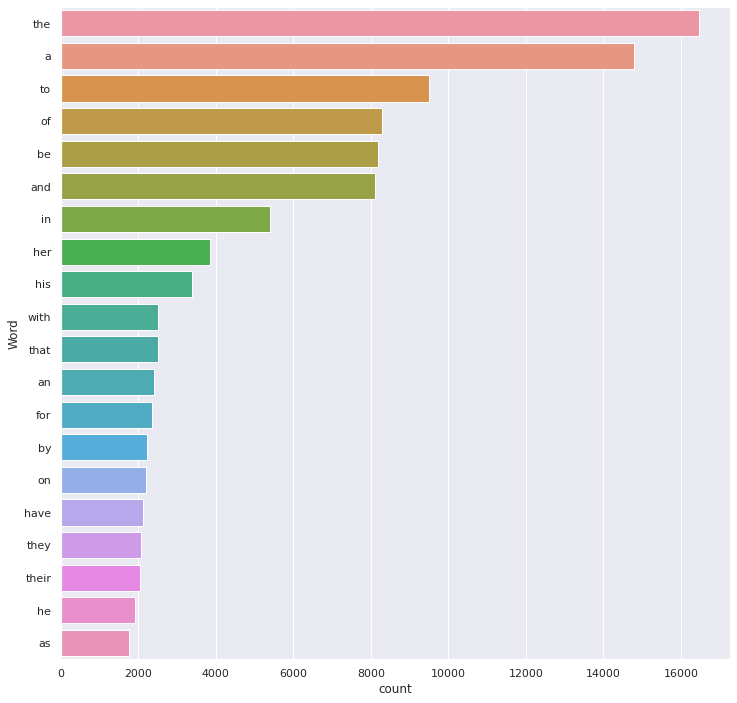

In [13]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,12)) 
  ax = sb.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(df['clean_overview'], 20)

4.3.1 As you may have noticed, the top most words that frequently appear are words that are universally used in overview writing. These are called stopwords. These stopwords carry far less meaning than other keywords in the text (they just add noise to the data). 

We are going to go ahead and remove them from the plots’ text. We obtained the list of stopwords from the nltk library:

Python NLTK provides WordNet Lemmatizer that uses the WordNet Database to lookup lemmas of words

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_overview'] = df['clean_overview'].apply(lambda x: remove_stopwords(x))

4.3.2 Now that we have removed the stopwords from our dataframe, the words shown on the new bar plot shows more distinct words that cater to certain genres.

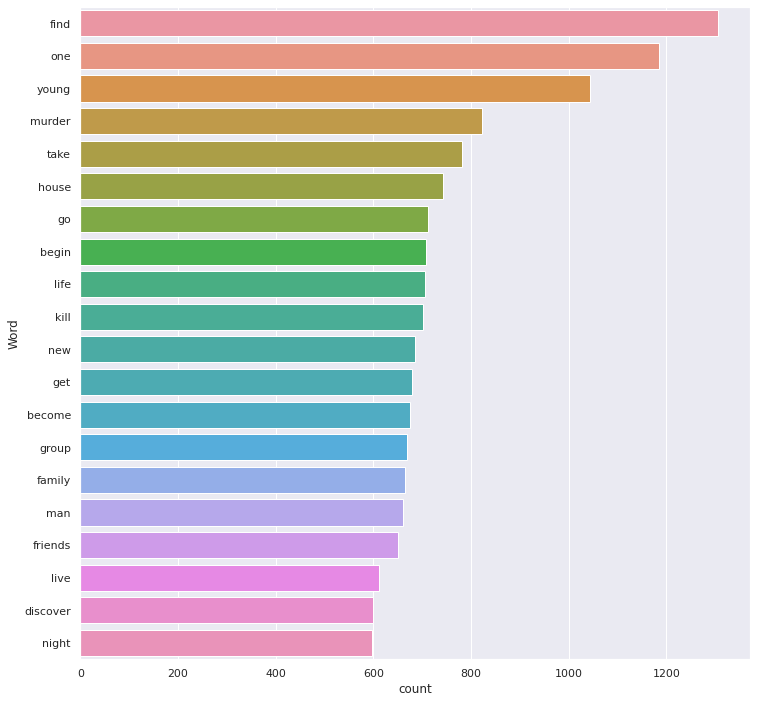

In [16]:
freq_words(df['clean_overview'], 20)

# 5. Creation of Genre Prediction Model (NMM - LTSM)

5.1 Added a column called overview_len to show the length of each overview 

In [17]:
df['overview_len'] = [len(i.split()) for i in df.clean_overview]
df.head(3)


,titles,overviews,genres,clean_overview,overview_len
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",[Horror],alice young hear impair girl suppose visitatio...,48
1,Wrong Turn,Jen and a group of friends set out to hike the...,"[Horror, Thriller]",jen group friends set hike appalachian trail d...,28
2,The Unfamiliar,"A British Army doctor comes back from a war, t...","[Thriller, Horror]",british army doctor come back war think ptsd d...,16


5.2 Used defaultdict to check the total number of each genres

In [18]:
from collections import defaultdict
genre_dict = defaultdict(int)
for idx in df.index:
    g = df.at[idx, 'genres']
    if type(g) == list:
        for genre in g:
            genre_dict[genre] += 1
genre_dict

defaultdict(int, {'Horror': 4672, 'Thriller': 2847})

5.3 The function df.explode('genres') is used to transform each element of the genres list to a row. By exploding, it will be easier to perform binary classification on the dataset.

In [19]:
df = df.explode('genres')

In [20]:
df = df.loc[df['genres'].isin(['Horror', 'Thriller'])]

In [21]:
df

,titles,overviews,genres,clean_overview,overview_len
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",Horror,alice young hear impair girl suppose visitatio...,48
1,Wrong Turn,Jen and a group of friends set out to hike the...,Horror,jen group friends set hike appalachian trail d...,28
1,Wrong Turn,Jen and a group of friends set out to hike the...,Thriller,jen group friends set hike appalachian trail d...,28
2,The Unfamiliar,"A British Army doctor comes back from a war, t...",Thriller,british army doctor come back war think ptsd d...,16
2,The Unfamiliar,"A British Army doctor comes back from a war, t...",Horror,british army doctor come back war think ptsd d...,16
...,...,...,...,...,...
9982,Porcelain Rising,A menacing porcelain doll comes to life at nig...,Horror,menace porcelain doll come life night terroriz...,14
9989,ฮาชิมะ โปรเจกต์ ไม่เชื่อ ต้องลบหลู่,Hashima Island was once the most densely popul...,Horror,hashima island densely populate island ghost i...,35
9990,Petrified,When a black market antiques deal is botched b...,Horror,black market antique deal botch goon girlfrien...,29
9992,Herbert West: Reanimator,"Pursued by the police, an ambitious neuroscien...",Horror,pursue police ambitious neuroscientist use neu...,21


5.4 Split the dataset to train data and test data using train_test_split

In [22]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(df, test_size=0.2, random_state=9)

5.5 Based on max and min length of the overview, we decided to set the max threshold to 140 and min threshold to 6 as overviews with length 5 and lower are too unlikely to be descriptive enough to determine the genre

In [23]:
overview_length = df["overview_len"]
max_value = overview_length.max()
min_value = overview_length.min()
print("The minimum length for overview is ",min_value)
print("The maximum length for overview is ",max_value)

The minimum length for overview is  1
The maximum length for overview is  150


In [24]:
min_overview_length=6
max_overview_length=140

train_data=train_data[(train_data.clean_overview.str.split().apply(len)>min_overview_length)].reset_index(drop=True)
test_data=test_data[(test_data.clean_overview.str.split().apply(len)>min_overview_length)].reset_index(drop=True)

In [25]:
train_data

,titles,overviews,genres,clean_overview,overview_len
0,The Tell-Tale Heart,"A haunting account of a tormented man, haunted...",Horror,haunt account torment man haunt heart man murd...,17
1,Red Lights,"Two investigators of paranormal hoaxes, the ve...",Thriller,two investigators paranormal hoax veteran dr m...,60
2,Diary of a Madman,"Simon Cordier, a French magistrate and amateur...",Horror,simon cordier french magistrate amateur sculpt...,21
3,Impossible Horror,"After Lily, an insomniac young filmmaker, star...",Horror,lily insomniac young filmmaker start hear recu...,39
4,Restless Souls,Newlyweds spend the night at a haunted mansion...,Horror,newlyweds spend night haunt mansion car troubl...,51
...,...,...,...,...,...
5915,The Manor,"""The Manor,"" is the macabre tale of mental pat...",Horror,manor macabre tale mental patient amy hunter h...,54
5916,The Visitant,"Samantha plays the role of ""Fortune Teller,"" b...",Thriller,samantha play role fortune teller thorough ske...,15
5917,Autopsy,"Emily Johnson, her boyfriend Bobby and their f...",Thriller,emily johnson boyfriend bobby friends clare ju...,32
5918,The Activist,A political thriller during the Wounded Knee i...,Thriller,political thriller wound knee insurrection two...,27


5.6 The index for exploded lists to rows are duplicated. Hence, we are unable to use the index to uniquely identify each row. We decided to add a new column that assigns a unique number to each row.  

In [26]:
train_data['unique_index'] = range(0, len(train_data))
test_data['unique_index'] = range(0, len(test_data))

In [27]:
train_data.head()

,titles,overviews,genres,clean_overview,overview_len,unique_index
0,The Tell-Tale Heart,"A haunting account of a tormented man, haunted...",Horror,haunt account torment man haunt heart man murd...,17,0
1,Red Lights,"Two investigators of paranormal hoaxes, the ve...",Thriller,two investigators paranormal hoax veteran dr m...,60,1
2,Diary of a Madman,"Simon Cordier, a French magistrate and amateur...",Horror,simon cordier french magistrate amateur sculpt...,21,2
3,Impossible Horror,"After Lily, an insomniac young filmmaker, star...",Horror,lily insomniac young filmmaker start hear recu...,39,3
4,Restless Souls,Newlyweds spend the night at a haunted mansion...,Horror,newlyweds spend night haunt mansion car troubl...,51,4


5.7 Clipping and padding the overviews

In [28]:
vocabulary=set() #unique list of all words from all of the overviews
def add_to_vocab(df
                 , vocabulary):
    for i in df.clean_overview:
        for word in i.split():
            vocabulary.add(word)
    return vocabulary
vocabulary=add_to_vocab(train_data, vocabulary)

vocab_dict={word: token+1 for token, word in enumerate(list(vocabulary))}

token_dict={token+1: word for token, word in enumerate(list(vocabulary))}
assert token_dict[1]==token_dict[vocab_dict[token_dict[1]]]

def tokenizer(ov, vocab_dict, max_overview_length):
    
    # dictionary mapping words to their corresponding tokens
    a=[vocab_dict[i] if i in vocab_dict else 0 for i in ov.split()]
    b=[0] * max_overview_length

    # Returns list of length max_desc_length, pre-padded with zeroes if the overview length was less than max_desc_length which is 140
    if len(a)<max_overview_length:
        return np.asarray(b[:max_overview_length-len(a)]+a).squeeze()
    else:
        return np.asarray(a[:max_overview_length]).squeeze()
len(vocabulary)
print("Unique Words: ",len(vocabulary))

Unique Words:  14697


5.8 Then, we tokenise each overview

In [29]:
train_data['overview_tokens']=train_data['clean_overview'].apply(tokenizer, args=(vocab_dict, max_overview_length))
test_data['overview_tokens']=test_data['clean_overview'].apply(tokenizer, args=(vocab_dict, max_overview_length))
train_data.head(2)

,titles,overviews,genres,clean_overview,overview_len,unique_index,overview_tokens
0,The Tell-Tale Heart,"A haunting account of a tormented man, haunted...",Horror,haunt account torment man haunt heart man murd...,17,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Red Lights,"Two investigators of paranormal hoaxes, the ve...",Thriller,two investigators paranormal hoax veteran dr m...,60,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [30]:
train_data.genres.value_counts() 

Horror      3678
Thriller    2242
Name: genres, dtype: int64

5.9 To ensure that the dataset is balanced, we perform stratified splitting on the dataset to ensure that the target variable is maintained in both the training and validation datasets

In [31]:
def stratified_split(df, target, val_percent=0.2):
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].unique_index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs
_, sample_idxs = stratified_split(train_data, 'genres', 0.1)

train_idxs, val_idxs = stratified_split(train_data, 'genres', val_percent=0.2)

sample_train_idxs, sample_val_idxs = stratified_split(train_data[train_data.unique_index.isin(sample_idxs)], 'genres', val_percent=0.2)

classes=list(train_data.genres.unique())

To ensure that the ratio of the genres are preserved

In [32]:
def test_stratified(df, col):
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')
    print("----------------------")

In [33]:
test_stratified(train_data, 'genres')
test_stratified(train_data[train_data.unique_index.isin(train_idxs)], 'genres')
test_stratified(train_data[train_data.unique_index.isin(val_idxs)], 'genres')
test_stratified(train_data[train_data.unique_index.isin(sample_train_idxs)], 'genres')
test_stratified(train_data[train_data.unique_index.isin(sample_val_idxs)], 'genres')

Proportion of records with Horror: 0.62 (3678 / 5920)
Proportion of records with Thriller: 0.38 (2242 / 5920)
----------------------
Proportion of records with Horror: 0.62 (2943 / 4737)
Proportion of records with Thriller: 0.38 (1794 / 4737)
----------------------
Proportion of records with Thriller: 0.38 (448 / 1183)
Proportion of records with Horror: 0.62 (735 / 1183)
----------------------
Proportion of records with Horror: 0.62 (294 / 474)
Proportion of records with Thriller: 0.38 (180 / 474)
----------------------
Proportion of records with Thriller: 0.38 (44 / 117)
Proportion of records with Horror: 0.62 (73 / 117)
----------------------


In [34]:
sampling=False

# z_train and y_train used to train the model and x_val and y_val are used to examine the validation accuracy
x_train=np.stack(train_data[train_data.unique_index.isin(sample_train_idxs if sampling else train_idxs)]['overview_tokens'])
y_train=train_data[train_data.unique_index.isin(sample_train_idxs if sampling else train_idxs)]['genres'].apply(lambda x:classes.index(x))

x_val=np.stack(train_data[train_data.index.isin(sample_val_idxs if sampling else val_idxs)]['overview_tokens'])
y_val=train_data[train_data.index.isin(sample_val_idxs if sampling else val_idxs)]['genres'].apply(lambda x:classes.index(x))

In [35]:
x_test=np.stack(test_data['overview_tokens'])
y_test=test_data['genres'].apply(lambda x:classes.index(x))

5.10 We will be implementing the LSTM model using Keras. We created 5 models with different parameters to see which model has the highest training accuracy and high validation accuracy 

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

# initialize model and add embedding layer
model = Sequential()
# decide on number of hidden nodes
model.add(Embedding(len(vocabulary)+1, output_dim=200, input_length=max_overview_length))

In [37]:
parameters = {'vocab': vocabulary,
              'eval_batch_size': 30,
              'batch_size': 20,
              'epochs': 5,
              'dropout': 0.2,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def movieLSTM(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Embedding(len(params['vocab'])+1, output_dim=x_train.shape[1], input_length=x_train.shape[1]))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(200))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
              optimizer=params['optimizer'],
              metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          batch_size=params['batch_size'], 
          epochs=params['epochs'])
    results = model.evaluate(x_test, y_test, batch_size=params['eval_batch_size'])
    return model

In [38]:
movieModel1 = movieLSTM(x_train, y_train, x_val, y_val, parameters)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 140)          2057720   
_________________________________________________________________
lstm (LSTM)                  (None, 140, 200)          272800    
_________________________________________________________________
dropout (Dropout)            (None, 140, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 2,651,521
Trainable params: 2,651,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
237/237 [==============================] - 158s 650ms/step - loss: 0.6685 - accuracy: 0.6151 - 

In [39]:
yhat_classes = movieModel1.predict_classes(x_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [40]:
yhat_classes = yhat_classes[:, 0]

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)

In [42]:
print('F1 score: %f' % f1)
print('Accuracy: %f' % accuracy)

F1 score: 0.280000
Accuracy: 0.562162


In [43]:
parameters = {'vocab': vocabulary,
              'eval_batch_size': 30,
              'batch_size': 128,
              'epochs': 2,
              'dropout': 0.2,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def movieLSTM(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Embedding(len(params['vocab'])+1, output_dim=x_train.shape[1], input_length=x_train.shape[1]))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(200))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
              optimizer=params['optimizer'],
              metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          batch_size=params['batch_size'], 
          epochs=params['epochs'])
    results = model.evaluate(x_test, y_test, batch_size=params['eval_batch_size'])
    return model

In [44]:
movieModel2 = movieLSTM(x_train, y_train, x_val, y_val, parameters)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 140)          2057720   
_________________________________________________________________
lstm_2 (LSTM)                (None, 140, 200)          272800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 200)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,651,521
Trainable params: 2,651,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
38/38 [==============================] - 62s 2s/step - loss: 0.6698 - accuracy: 0.6123 - val_lo

In [45]:
yhat_classes = movieModel2.predict_classes(x_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [46]:
yhat_classes = yhat_classes[:, 0]

In [47]:
yhat_classes = movieModel2.predict_classes(x_test, verbose=0)
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
print('Accuracy: %f' % accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 score: 0.387230
Accuracy: 0.597973


In [48]:

parameters = {'vocab': vocabulary,
              'eval_batch_size': 40,
              'batch_size': 128,
              'epochs': 3,
              'dropout': 0.3,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def movieLSTM(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Embedding(len(params['vocab'])+1, output_dim=x_train.shape[1], input_length=x_train.shape[1]))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(200))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
              optimizer=params['optimizer'],
              metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          batch_size=params['batch_size'], 
          epochs=params['epochs'])
    results = model.evaluate(x_test, y_test, batch_size=params['eval_batch_size'])
    return model



In [49]:
movieModel3 = movieLSTM(x_train, y_train, x_val, y_val, parameters)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 140)          2057720   
_________________________________________________________________
lstm_4 (LSTM)                (None, 140, 200)          272800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 140, 200)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,651,521
Trainable params: 2,651,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
38/38 [==============================] - 62s 2s/step - loss: 0.6711 - accuracy: 0.6114 - val_lo

In [50]:
yhat_classes = movieModel3.predict_classes(x_test, verbose=0)
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
print('Accuracy: %f' % accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 score: 0.415225
Accuracy: 0.543243


In [51]:
parameters = {'vocab': vocabulary,
              'eval_batch_size': 40,
              'batch_size': 128,
              'epochs': 5,
              'dropout': 0.4,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def movieLSTM(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Embedding(len(params['vocab'])+1, output_dim=x_train.shape[1], input_length=x_train.shape[1]))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(200))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
              optimizer=params['optimizer'],
              metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          batch_size=params['batch_size'], 
          epochs=params['epochs'])
    results = model.evaluate(x_test, y_test, batch_size=params['eval_batch_size'])
    return model



In [52]:
movieModel4 = movieLSTM(x_train, y_train, x_val, y_val, parameters)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 140, 140)          2057720   
_________________________________________________________________
lstm_6 (LSTM)                (None, 140, 200)          272800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 140, 200)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 2,651,521
Trainable params: 2,651,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
38/38 [==============================] - 62s 2s/step - loss: 0.6834 - accuracy: 0.6135 - val_lo

In [53]:
yhat_classes = movieModel4.predict_classes(x_test, verbose=0)
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
print('Accuracy: %f' % accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 score: 0.360568
Accuracy: 0.513514


In [54]:
parameters = {'vocab': vocabulary,
              'eval_batch_size': 40,
              'batch_size': 128,
              'epochs': 5,
              'dropout': 0,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def movieLSTM(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Embedding(len(params['vocab'])+1, output_dim=x_train.shape[1], input_length=x_train.shape[1]))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(200))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
              optimizer=params['optimizer'],
              metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          batch_size=params['batch_size'], 
          epochs=params['epochs'])
    results = model.evaluate(x_test, y_test, batch_size=params['eval_batch_size'])
    return model

In [55]:
movieModel5 = movieLSTM(x_train, y_train, x_val, y_val, parameters)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 140, 140)          2057720   
_________________________________________________________________
lstm_8 (LSTM)                (None, 140, 200)          272800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 140, 200)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 2,651,521
Trainable params: 2,651,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
38/38 [==============================] - 62s 2s/step - loss: 0.6747 - accuracy: 0.6089 - val_lo

In [56]:
yhat_classes = movieModel5.predict_classes(x_test, verbose=0)
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
print('Accuracy: %f' % accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F1 score: 0.386880
Accuracy: 0.507432


5.11 The function reviewMovie is used to predict the genre of the movie using the overview. Based on the results we got, movieModel2 is the ideal model as it has the highest training accuracy and relatively high f1-score with the lowest loss. The lower the loss, the closer our predictions to be to the true genres. 

In [57]:
def reviewMovie(model,text):
    labels = ['Horror', 'Thriller']
    a = clean_text(text)
    a = tokenizer(a, vocab_dict, max_overview_length)
    a = np.reshape(a, (1,max_overview_length))
    output = model.predict(a, batch_size=1)
    score = (output>0.5)*1
    pred = score.item()
    return labels[pred]

In [58]:
predicted = []
count = 0
for i in df.overviews:
  predicted.append(reviewMovie(movieModel2,i))
  count = count + 1

df['predicted_genres'] = predicted

In [59]:
df

,titles,overviews,genres,clean_overview,overview_len,predicted_genres
0,The Unholy,"Alice, a young hearing-impaired girl who, afte...",Horror,alice young hear impair girl suppose visitatio...,48,Horror
1,Wrong Turn,Jen and a group of friends set out to hike the...,Horror,jen group friends set hike appalachian trail d...,28,Thriller
1,Wrong Turn,Jen and a group of friends set out to hike the...,Thriller,jen group friends set hike appalachian trail d...,28,Thriller
2,The Unfamiliar,"A British Army doctor comes back from a war, t...",Thriller,british army doctor come back war think ptsd d...,16,Thriller
2,The Unfamiliar,"A British Army doctor comes back from a war, t...",Horror,british army doctor come back war think ptsd d...,16,Thriller
...,...,...,...,...,...,...
9982,Porcelain Rising,A menacing porcelain doll comes to life at nig...,Horror,menace porcelain doll come life night terroriz...,14,Horror
9989,ฮาชิมะ โปรเจกต์ ไม่เชื่อ ต้องลบหลู่,Hashima Island was once the most densely popul...,Horror,hashima island densely populate island ghost i...,35,Horror
9990,Petrified,When a black market antiques deal is botched b...,Horror,black market antique deal botch goon girlfrien...,29,Horror
9992,Herbert West: Reanimator,"Pursued by the police, an ambitious neuroscien...",Horror,pursue police ambitious neuroscientist use neu...,21,Horror


5.12 Conclusion

Based on the results we obtained from training and testing, it shows that our assumption is *incorrect*. With a smaller number of genres, it does not mean that the accuracy of the model will increase. 

| **Models** | NLP - MLC | multinomialNB | LinearSVC | NMM - LSTM |
| --- | --- | --- | --- | --- |
| **Accuracy** | 0.311902 | 0.343783 | 0.310840 | 0.368996 |
| **F1-score** | 0.703772 | 0.652189 | 0.619505 | 0.602749 |

NLP - MLC, multinomial NB and LinearSVC models which uses 5 genres has a higher accuracy score than NMM - LSTM model which uses only 2 genres

> `NLP - MLC` remains as the best predictor of genres for our dataset, and we have acheived our goal of exploring various models to predict the genre of a movie based on it overview.
